# Crop CBP Data

This notebook removes any CBP stations that do not lie within the vector boundary of any of the 3 satellite datasets.

In [45]:
from pathlib import Path

from geocube.vector import vectorize
import xarray as xr
import pandas as pd
import geopandas as gpd

In [7]:
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

In [9]:
geopolar_filename = (
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc'
)
mur_filename = (
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-CB-20030101_20231231.nc'
)
ostia_filename = (
    'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc'
)  

In [13]:
geopolar = xr.open_dataset(
    REPO_ROOT / 'data/01_raw' / geopolar_filename
).analysed_sst
mur = xr.open_dataset(
    REPO_ROOT / 'data/01_raw' / mur_filename
).analysed_sst
ostia = xr.open_dataset(
    REPO_ROOT / 'data/01_raw' / ostia_filename
).analysed_sst

In [27]:
sat_shapes = gpd.GeoDataFrame(columns=['satellite', 'geometry'])

In [38]:
geop_vector = vectorize(geopolar.isel(time=0))
mur_vector = vectorize(mur.isel(time=0))
ostia_vector = vectorize(ostia.isel(time=0))

In [39]:
sat_shapes.loc[0] = ['geopolar', geop_vector.dissolve().iloc[0].geometry]
sat_shapes.loc[1] = ['mur', mur_vector.dissolve().iloc[0].geometry]
sat_shapes.loc[2] = ['ostia', ostia_vector.dissolve().iloc[0].geometry]

In [40]:
sat_shapes

,satellite,geometry
0,geopolar,"POLYGON ((-76.75000 37.10000, -76.75000 37.150..."
1,mur,"MULTIPOLYGON (((-76.91500 37.24500, -76.90500 ..."
2,ostia,"POLYGON ((-77.00000 37.15000, -77.00000 37.250..."


In [48]:
cbp_df = pd.read_csv(
    REPO_ROOT / 'data/01_raw' / 
    'WaterQuality_ChesapeakeBayProgram_20030101_20231231_Temp.csv'
)

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2338/3061268995.py:1: DtypeWarning: Columns (18,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  cbp_df = pd.read_csv(


In [50]:
cbp_gdf = gpd.GeoDataFrame(
    cbp_df, geometry=gpd.points_from_xy(cbp_df.Longitude, cbp_df.Latitude),
    crs="EPSG:4326"
)

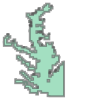

In [55]:
sat_shapes.dissolve().loc[0, 'geometry']

This step can take some time. Typically ran in ~15 minutes on my computer.

In [58]:
%%time

cbp_gdf_masked = cbp_gdf[cbp_gdf.within(sat_shapes.dissolve().loc[0, 'geometry'])]

CPU times: user 13min 12s, sys: 18.7 s, total: 13min 31s
Wall time: 14min 24s


In [65]:
cbp_gdf_masked = cbp_gdf_masked.reset_index(drop=True)

In [66]:
cbp_gdf_masked.to_csv(
    REPO_ROOT / 'data/01_raw' / 
    'WaterQuality_ChesapeakeBayProgram_20030101_20231231_Temp.csv', 
    index=False
)